In [1]:
import perceval as pcvl
from perceval.algorithm import Sampler
import sympy as sp
import numpy as np
from scipy import optimize

np.random.seed(0)

# Knill et al.'s CZ gate
Reproducing the results from [5].

The definition of beam splitter in [5] is
$$
u\left(\mathbf{B}_{\theta, \phi}\right)=\left(\begin{array}{cc}
\cos (\theta) & -e^{i \phi} \sin (\theta) \\
e^{-i \phi} \sin (\theta) & \cos (\theta)
\end{array}\right).
$$
Therefore,
$$
\begin{align*}
\text{Convention} &= Ry \\
\phi_{tl} + \phi_{tr} &= 0 \\
\phi_{tr} + \phi_{bl} &= \phi \\
\phi_{tl} + \phi_{br} &= -\phi \\
\phi_{br} + \phi_{bl} &= 0 \\
\theta_{pcvl} &= 2\theta_{paper}
\end{align*}
$$

In [2]:
def new_BS(theta, phi):
    return pcvl.BS.Ry(
        theta=2 * theta,
        phi_tl=-phi / 2,
        phi_tr=phi / 2,
        phi_bl=phi / 2,
        phi_br=-phi / 2,
    )


def new_PS(phi):
    return pcvl.PS(phi=phi)


def deg_to_rad(deg):
    return deg * sp.pi / 180

In [3]:
new_BS(sp.Symbol("theta"), sp.Symbol("phi")).U

Matrix([
[            cos(theta), -exp(I*phi)*sin(theta)],
[exp(-I*phi)*sin(theta),             cos(theta)]])

In [4]:
new_PS(sp.Symbol("phi")).U

Matrix([[exp(I*phi)]])

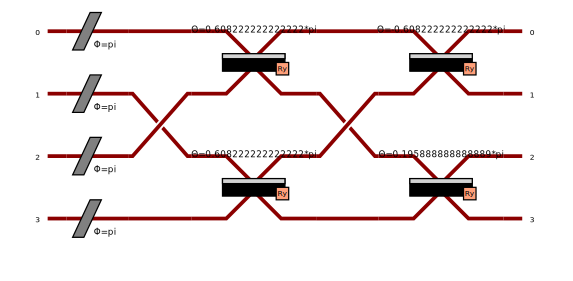

In [5]:
cz = pcvl.Circuit(4, name="Knill CZ")
cz.add((0), new_PS(phi=deg_to_rad(180)))
cz.add((1), new_PS(phi=deg_to_rad(180)))
cz.add((2), new_PS(phi=deg_to_rad(180)))
cz.add((3), new_PS(phi=deg_to_rad(180)))
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(54.74), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(54.74), phi=deg_to_rad(0)),
)
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(-54.74), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(17.63), phi=deg_to_rad(0)),
)

pcvl.pdisplay(cz)

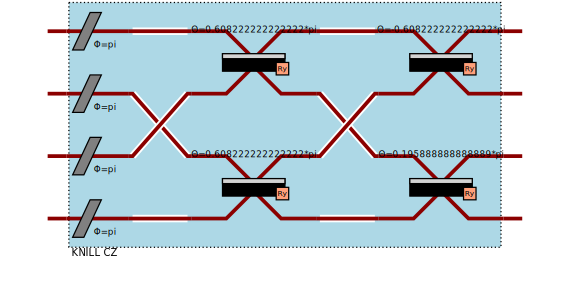

In [6]:
p = pcvl.Processor("SLOS", cz)
p.with_input(pcvl.BasicState("|0,0,1,1>"))
# p.set_postselection(pcvl.PostSelect("[2]==1 & [3]==1"))
pcvl.pdisplay(p, recursive=True)

In [7]:
sampler = Sampler(p)
sampler.probs()["results"]

BSDistribution(float,
               {|2,0,0,0>: 0.19755225896088607,
                |1,1,0,0>: 0.04943623948445133,
                |1,0,1,0>: 0.08088630531311354,
                |1,0,0,1>: 0.14131183475569667,
                |0,2,0,0>: 0.19755225896088607,
                |0,1,1,0>: 0.14131183475569667,
                |0,1,0,1>: 0.08088630531311354,
                |0,0,2,0>: 0.018506482658913782,
                |0,0,1,1>: 0.07404999713832859,
                |0,0,0,2>: 0.018506482658913782})

if the probability of `|*,*,1,1>` is equal to 2/27=0.07407407407407407..., then it is correct

Checking the matrix representation:

In [8]:
cz.U

Matrix([
[                        -1.0*cos(0.304111111111111*pi)**2,                            -0.5*sin(0.391777777777778*pi),                             0.5*sin(0.391777777777778*pi),                          1.0*sin(0.304111111111111*pi)**2],
[                            0.5*sin(0.391777777777778*pi),                         -1.0*cos(0.304111111111111*pi)**2,                         -1.0*sin(0.304111111111111*pi)**2,                             0.5*sin(0.391777777777778*pi)],
[-1.0*sin(0.304111111111111*pi)*cos(0.0979444444444444*pi),  1.0*sin(0.0979444444444444*pi)*sin(0.304111111111111*pi), -1.0*cos(0.0979444444444444*pi)*cos(0.304111111111111*pi),  1.0*sin(0.0979444444444444*pi)*cos(0.304111111111111*pi)],
[-1.0*sin(0.0979444444444444*pi)*sin(0.304111111111111*pi), -1.0*sin(0.304111111111111*pi)*cos(0.0979444444444444*pi), -1.0*sin(0.0979444444444444*pi)*cos(0.304111111111111*pi), -1.0*cos(0.0979444444444444*pi)*cos(0.304111111111111*pi)]])

In [9]:
from sympy import matrix2numpy

cz_U = matrix2numpy(cz.U, dtype=float)
print(cz_U)

[[-0.3332611  -0.47137898  0.47137898  0.6667389 ]
 [ 0.47137898 -0.3332611  -0.6667389   0.47137898]
 [-0.7781897   0.24730485 -0.55017379  0.17484252]
 [-0.24730485 -0.7781897  -0.17484252 -0.55017379]]


In [10]:
ans = np.array(
    [
        [-1 / 3, -np.sqrt(2) / 3, np.sqrt(2) / 3, 2 / 3],
        [np.sqrt(2) / 3, -1 / 3, -2 / 3, np.sqrt(2) / 3],
        [
            -np.sqrt(3 + np.sqrt(6)) / 3,
            np.sqrt(3 - np.sqrt(6)) / 3,
            -np.sqrt((3 + np.sqrt(6)) / 2) / 3,
            np.sqrt(1 / 6 - 1 / (3 * np.sqrt(6))),
        ],
        [
            -np.sqrt(3 - np.sqrt(6)) / 3,
            -np.sqrt(3 + np.sqrt(6)) / 3,
            -np.sqrt(1 / 6 - 1 / (3 * np.sqrt(6))),
            -np.sqrt((3 + np.sqrt(6)) / 2) / 3,
        ],
    ]
)
print(ans)

[[-0.33333333 -0.47140452  0.47140452  0.66666667]
 [ 0.47140452 -0.33333333 -0.66666667  0.47140452]
 [-0.77813807  0.24732126 -0.55022671  0.17488254]
 [-0.24732126 -0.77813807 -0.17488254 -0.55022671]]


In [11]:
np.linalg.norm(cz_U - ans)

0.00019532920397359648

Try parameter optimization:

In [12]:
def optfunc(params):
    cz = pcvl.Circuit(4, name="CZ")
    cz.add((0), new_PS(phi=deg_to_rad(180)))
    cz.add((1), new_PS(phi=deg_to_rad(180)))
    cz.add((2), new_PS(phi=deg_to_rad(180)))
    cz.add((3), new_PS(phi=deg_to_rad(180)))
    cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
    cz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
    )
    cz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
    )
    cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
    cz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
    )
    cz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
    )

    c = (
        pcvl.Circuit(6, name="Heralded CZ")
        .add(1, pcvl.PERM([1, 0]))
        .add(2, cz, merge=True)
        .add(1, pcvl.PERM([1, 0]))
    )

    p = pcvl.Processor("SLOS", 6)
    p.add(2, pcvl.BS.H())
    p.add(0, c)
    p.add(2, pcvl.BS.H())
    p.add_herald(4, 1)
    p.add_herald(5, 1)

    states = {
        pcvl.BasicState([1, 0, 1, 0]): "00",
        pcvl.BasicState([1, 0, 0, 1]): "01",
        pcvl.BasicState([0, 1, 1, 0]): "10",
        pcvl.BasicState([0, 1, 0, 1]): "11",
    }

    ca = pcvl.algorithm.Analyzer(p, states)

    truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}

    ca.compute(expected=truth_table)

    return 1 - ca.fidelity

In [13]:
init = np.random.rand(4) * 180
res = optimize.minimize(optfunc, init, bounds=[(0, 180)] * 4)
res

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:360: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: (7.530109868980617e-11+0j)
        x: [ 1.002e+02  1.280e+02  1.080e+02  9.593e+01]
      nit: 6
      jac: [-5.551e-08  8.438e-07  3.886e-07  1.776e-07]
     nfev: 35
     njev: 7
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

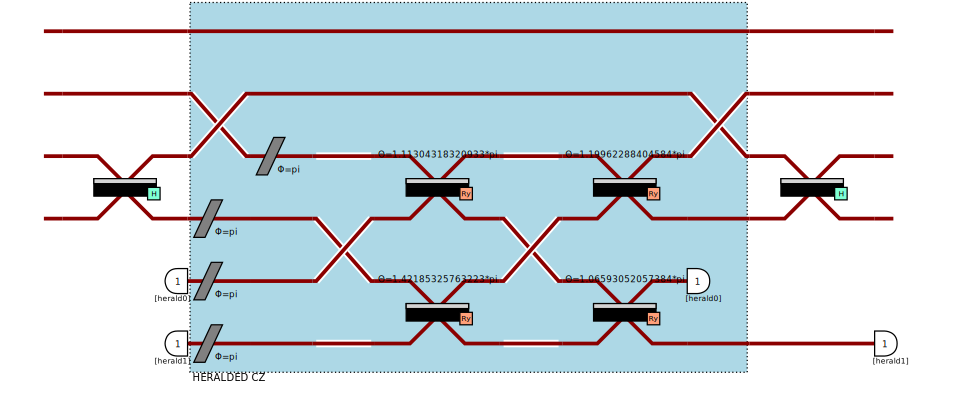

In [14]:
params = res.x

cz = pcvl.Circuit(4, name="Knill CZ")
cz.add((0), new_PS(phi=deg_to_rad(180)))
cz.add((1), new_PS(phi=deg_to_rad(180)))
cz.add((2), new_PS(phi=deg_to_rad(180)))
cz.add((3), new_PS(phi=deg_to_rad(180)))
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
)
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
)

c = (
    pcvl.Circuit(6, name="Heralded CZ")
    .add(1, pcvl.PERM([1, 0]))
    .add(2, cz, merge=True)
    .add(1, pcvl.PERM([1, 0]))
)


p = pcvl.Processor("SLOS", 6)
p.add(2, pcvl.BS.H())
p.add(0, c)
p.add(2, pcvl.BS.H())
p.add_herald(4, 1)
p.add_herald(5, 1)

pcvl.pdisplay(p, recursive=True)

In [15]:
states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11",
}

ca = pcvl.algorithm.Analyzer(p, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}

ca.compute(expected=truth_table)
pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

performance = 0.01135611779686673, fidelity = 0.9999999999246989


In [16]:
# reference

processor = pcvl.Processor("SLOS", 4)
processor.add(2, pcvl.BS.H())
processor.add(0, pcvl.catalog["heralded cz"].build_processor())
processor.add(2, pcvl.BS.H())

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11",
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

performance = 0.0740660484285117, fidelity = 0.9999999915267557


# CCZ parameter optimization

In [17]:
# define the optimization function


def optfunc(params):
    ccz = pcvl.Circuit(6, name="CCZ")
    ccz.add((0), new_PS(phi=deg_to_rad(180)))
    ccz.add((1), new_PS(phi=deg_to_rad(180)))
    ccz.add((2), new_PS(phi=deg_to_rad(180)))
    ccz.add((3), new_PS(phi=deg_to_rad(180)))
    ccz.add((4), new_PS(phi=deg_to_rad(180)))
    ccz.add((5), new_PS(phi=deg_to_rad(180)))
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))
    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[4]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[5]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[6]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[7]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[8]), phi=deg_to_rad(0)),
    )

    c = (
        pcvl.Circuit(9, name="Heralded CCZ")
        .add(0, pcvl.PERM([0, 3, 1, 4, 2, 5]))
        .add(3, ccz, merge=True)
        .add(0, pcvl.PERM([0, 2, 4, 1, 3, 5]))
    )

    p = pcvl.Processor("SLOS", 9)
    p.add(4, pcvl.BS.H())
    p.add(0, c)
    p.add(4, pcvl.BS.H())
    p.add_herald(6, 1)
    p.add_herald(7, 1)
    p.add_herald(8, 1)

    states = {
        pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
        pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
        pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
        pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
        pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
        pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
        pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
        pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
    }

    ca = pcvl.algorithm.Analyzer(p, states)

    truth_table = {
        "000": "000",
        "001": "001",
        "010": "010",
        "011": "011",
        "100": "100",
        "101": "101",
        "110": "111",
        "111": "110",
    }
    ca.compute(expected=truth_table)

    return 1 - ca.fidelity  # minimize the infidelity

Do optimization with various methods:

In [18]:
init = np.random.rand(9) * 180
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

KeyboardInterrupt: 

In [ ]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "BFGS", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/_lib/array_api_compat/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:350: ComplexWarning: Casting complex values to real discards the imaginary part
  w = math.exp(min(0, prod))


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: (1.8723911310303265e-12+0j)
                          x: [166.47288518+0.j  -7.58768048+0.j
                               38.67995325+0.j  36.82542778+0.j
                              154.55545705+0.j 132.10426225+0.j
                              145.99375252+0.j 157.36533038+0.j
                              157.09670887+0.j]
                        nit: 100
      minimization_failures: 0
                       nfev: 37360
                       njev: 3736
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: (1.8723911310303265e-12+0j)
                                    x: [166.47288518+0.j  -7.58768048+0.j
                                         38.67995325+0.j  36.82542778

In [ ]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "SLSQP", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:431: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: (4.218958260526762e-08+0j)
                          x: [ 1.267e+02  1.694e+02  1.596e+02  1.159e+02
                               1.567e+02  4.680e+01  1.462e+02  3.581e+01
                               7.389e+01]
                        nit: 100
      minimization_failures: 0
                       nfev: 13846
                       njev: 1376
 lowest_optimization_result: message: Optimization terminated successfully
                             success: True
                              status: 0
                                 fun: (4.218958260526762e-08+0j)
                                   x: [ 1.267e+02  1.694e+02  1.596e+02
                                        1.159e+02  1.567e+02  4.680e+01
                                        1.462e+02  3.581e+01  7.389e+01]
                                 nit: 22
      

In [ ]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "Nelder-Mead", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:923: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:959: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxe
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:962: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxr
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.0
                          x: [ 1.798e+02  5.108e+00  4.451e+01  1.681e+02
                               1.351e+02  1.371e+02  1.333e+02  1.622e+02
                               6.478e+01]
                        nit: 100
      minimization_failures: 0
                       nfev: 40118
 lowest_optimization_result:       message: Optimization terminated successfully.
                                   success: True
                                    status: 0
                                       fun: 0.0
                                         x: [ 1.798e+02  5.108e+00
                                              4.451e+01  1.681e+02
                                              1.351e+02  1.371e+02
                                              1.333e+02  1.622e+02
                                              6.478

In [ ]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "Powell", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

TypeError: This operation is not supported for complex128 values because it would be ambiguous.

Testing the optimized parameters:

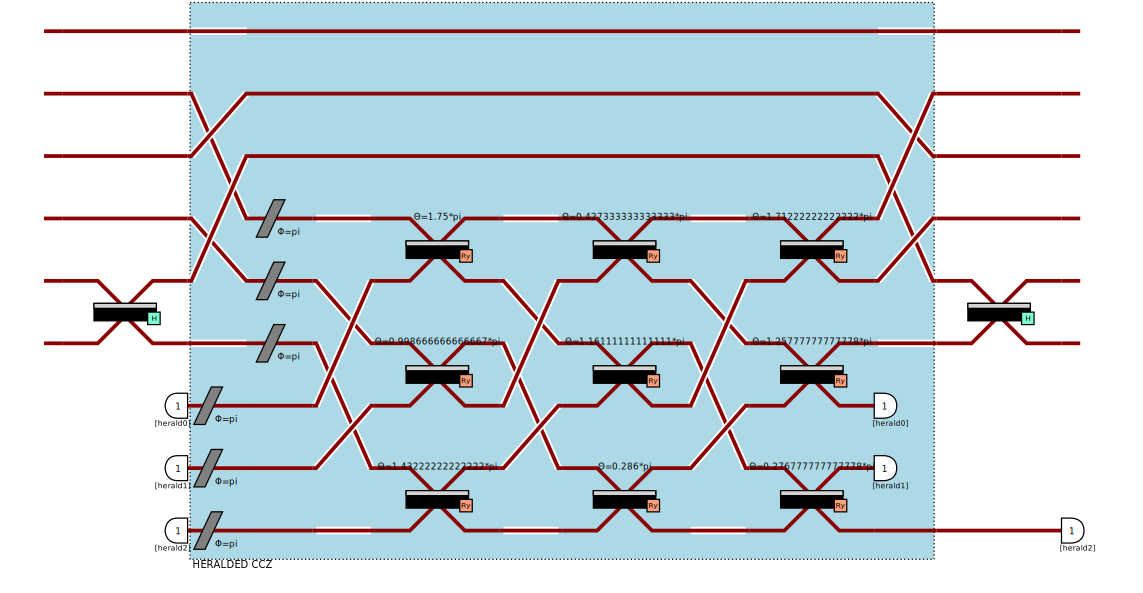

In [ ]:
params = [
    1.575e02,
    8.988e01,
    1.289e02,
    3.846e01,
    1.045e02,
    2.574e01,
    1.541e02,
    1.132e02,
    2.491e01,
]
ccz = pcvl.Circuit(6, name="CCZ")
ccz.add((0), new_PS(phi=deg_to_rad(180)))
ccz.add((1), new_PS(phi=deg_to_rad(180)))
ccz.add((2), new_PS(phi=deg_to_rad(180)))
ccz.add((3), new_PS(phi=deg_to_rad(180)))
ccz.add((4), new_PS(phi=deg_to_rad(180)))
ccz.add((5), new_PS(phi=deg_to_rad(180)))
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))
ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
)
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[4]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[5]), phi=deg_to_rad(0)),
)
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[6]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[7]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[8]), phi=deg_to_rad(0)),
)

c = (
    pcvl.Circuit(9, name="Heralded CCZ")
    .add(0, pcvl.PERM([0, 3, 1, 4, 2, 5]))
    .add(3, ccz, merge=True)
    .add(0, pcvl.PERM([0, 2, 4, 1, 3, 5]))
)

p = pcvl.Processor("SLOS", 9)
p.add(4, pcvl.BS.H())
p.add(0, c)
p.add(4, pcvl.BS.H())
p.add_herald(6, 1)
p.add_herald(7, 1)
p.add_herald(8, 1)

pcvl.pdisplay(p, recursive=True)

In [ ]:
states = {
    pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
    pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
    pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
    pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
    pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
    pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
    pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
    pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
}

ca = pcvl.algorithm.Analyzer(p, states)

truth_table = {
    "000": "000",
    "001": "001",
    "010": "010",
    "011": "011",
    "100": "100",
    "101": "101",
    "110": "111",
    "111": "110",
}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

performance = 0.028075761718527957, fidelity = 0.999923727920168


In [ ]:
# reference

processor = pcvl.Processor("SLOS", 6)
processor.add(4, pcvl.BS.H())
processor.add(0, pcvl.catalog["postprocessed ccz"].build_processor())
processor.add(4, pcvl.BS.H())

states = {
    pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
    pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
    pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
    pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
    pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
    pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
    pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
    pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {
    "000": "000",
    "001": "001",
    "010": "010",
    "011": "011",
    "100": "100",
    "101": "101",
    "110": "111",
    "111": "110",
}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

performance = 0.017559993780020683, fidelity = 1.0


Use new optfunc:

In [23]:
# define the optimization function
from auto_grader import (
    get_score,
    CriteriaType,
    get_photon_number,
    get_proba_amplitude_error,
)
import sys

def optfunc(params):
    ccz = pcvl.Circuit(6, name="CCZ")
    ccz.add((0), new_PS(phi=deg_to_rad(180)))
    ccz.add((1), new_PS(phi=deg_to_rad(180)))
    ccz.add((2), new_PS(phi=deg_to_rad(180)))
    ccz.add((3), new_PS(phi=deg_to_rad(180)))
    ccz.add((4), new_PS(phi=deg_to_rad(180)))
    ccz.add((5), new_PS(phi=deg_to_rad(180)))
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))
    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[4]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[5]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[6]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[7]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[8]), phi=deg_to_rad(0)),
    )

    c = (
        pcvl.Circuit(9, name="Heralded CCZ")
        .add(0, pcvl.PERM([0, 3, 1, 4, 2, 5]))
        .add(3, ccz, merge=True)
        .add(0, pcvl.PERM([0, 2, 4, 1, 3, 5]))
    )

    p = pcvl.Processor("SLOS", 9)
    p.add(4, pcvl.BS.H())
    p.add(0, c)
    p.add(4, pcvl.BS.H())
    p.add_herald(6, 1)
    p.add_herald(7, 1)
    p.add_herald(8, 1)

    states = {
        pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
        pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
        pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
        pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
        pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
        pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
        pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
        pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
    }

    analyzer = pcvl.algorithm.Analyzer(p, states)

    truth_table = {
        "000": "000",
        "001": "001",
        "010": "010",
        "011": "011",
        "100": "100",
        "101": "101",
        "110": "111",
        "111": "110",
    }
    analyzer.compute(expected=truth_table)

    criteria = {
        "n_photons": {"method": "log", "direction": "minus", "weight": 1e-3},
        "n_modes": {"method": "log", "direction": "minus", "weight": 1e-4},
        "performance": {"method": "log", "direction": "plus", "weight": 10},
        "prob_amplitude_error": {"method": "log", "direction": "minus", "weight": 1e7},
    }

    score = 0

    for criteria_name in criteria:
        current_criteria = CriteriaType[criteria_name]

        if current_criteria == CriteriaType.n_photons:
            score += get_score(current_criteria.name, criteria, get_photon_number(p))

        elif current_criteria == CriteriaType.n_modes:
            score += get_score(current_criteria.name, criteria, p.circuit_size)

        elif current_criteria == CriteriaType.performance:
            score += get_score(current_criteria.name, criteria, analyzer.performance)

        elif current_criteria == CriteriaType.prob_error:
            score += get_score(current_criteria.name, criteria, 1 - analyzer.fidelity)

        elif current_criteria == CriteriaType.prob_amplitude_error:
            get_proba_amplitude_error(p, states.keys(), [pcvl.BasicState("|0,1,0,1,0,1>")])
            score += get_score(current_criteria.name, criteria, 1 - analyzer.fidelity)

    print(params)
    print("\r", score, end="")
    return -score  # minimize the negative score

In [24]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "BFGS", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.016092250167295534, score is 0.15964142443210386
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.7467941058210082, score is -5577821.68351197
[139.3620641   82.1070598  102.3181108    3.38216408 111.17438947
 110.17723009 111.04811944 169.87465413 122.72765384]
 -5577821.526046714For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minu

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.01086397550726093, score is 0.10805386483207037
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.7319479184152442e-14, score is -1.731947918415229e-07
[115.53346936 143.20810592  64.47225215 131.5913088   49.75388443
 118.3170855   92.73529248 189.4944255  117.7095415 ]
 0.1058775229789238For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0006365521749137626, score is -6363.496615138527
[115.39297772 143.14513855  64.66988339 131.15153435  49.92065085
 118.48772331  92.44567538 189.12335181 117.52496961]
 -6363.39010446208For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010927963225212257, score is 0.10868684507842163
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0006365521449772649, score is -6363.49631596399
[115.39297772 143.14513855  64.66988337 13

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010904685542021503, score is 0.1084565818743331
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.7430501486614958e-14, score is -1.731947918415229e-07
[115.25701208 143.37260265  64.19880728 130.51094312  49.46779924
 118.45698895  93.07960354 187.02002021 119.16978424]
 0.10628024002118654For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria typ

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.011235845101340663, score is 0.11173191865000545
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0006874838345367618, score is -6872.476257789888
[115.32721122 143.31120188  64.68717753 130.1129864   49.1766772
 118.11829868  93.23271203 186.77331533 119.13609501]
 -6872.366702039896For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is m

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010708408791076743, score is 0.10651479833413337
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.6890933096647132e-12, score is -1.6890933096632868e-05
[115.23357288 143.05867491  64.710977   130.24859713  49.19611054
 118.71166323  93.2942956  186.76719997 119.22609026]
 0.10432173874268201For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria t

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010595526939123119, score is 0.10539787722122668
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0015215293460992818, score is -15203.729931251484
[114.89258181 142.66921346  64.8672936  129.88679676  48.8926866
 118.58027593  93.61553978 186.36409844 119.56407917]
 -15203.626709542921For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010153177597558072, score is 0.10101980341484405
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 2.5759394617352882e-12, score is -2.5759394617319705e-05
[115.07213779 142.09409459  64.97125766 130.20299776  49.32775321
 119.03627203  93.81702281 186.31287271 119.59275663]
 0.098817875361872For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria typ

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010797672442462606, score is 0.10739793840749282
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0006879468536611366, score is -6877.103266968427
[115.54869734 142.06324657  65.44850587 130.30786697  49.56669616
 118.57527397  93.60029933 185.93295276 119.3886665 ]
 -6876.9980451986785For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.3292700273837e-12, score is -1.3291590050803541e-05
[113.62969196 143.4761826   66.08818668 129.62086096  48.19566617
 118.38535359  94.30125781 182.15626295 122.13580001]
 0.1262160343078967For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.012923343305234041, score is 0.12840549456742506
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.3292700273837e-12, score is -1.3291590050803541e-05
[113.62969196 143.4761826   66.088

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.013041860942383831, score is 0.129575481465883
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.004468403715256031, score is -44584.5003972032
[113.44767514 143.39044559  65.65233417 129.81333308  48.26226762
 118.15074308  94.32450586 181.75020346 122.21174651]
 -44584.372997890394For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is min

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.011618138683903358, score is 0.11551166340843634
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 1.8919310562637293e-12, score is -1.891820033959477e-05
[112.87644333 142.92592254  64.99307517 130.25003082  48.87647358
 118.48038337  92.90985578 181.78963489 123.23961462]
 0.11331657654974202For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria ty

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.011222021175686997, score is 0.1115952144359475
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.00874872352332734, score is -87106.75196836468
[112.69500796 143.09333158  64.62487719 130.46636888  48.66588338
 118.16357426  92.99637119 181.30975391 123.56854828]
 -87106.6425493189For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minu

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.012161200399081772, score is 0.12087847112038011
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 4.656608432185294e-12, score is -4.6567194544769146e-05
[112.40137851 143.36848757  65.74264206 130.78046     48.73950253
 118.23604086  93.39628838 181.71103333 123.18515092]
 0.11865573526748062For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria ty

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.012406739672583903, score is 0.12330406790916752
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.005625481204873384, score is -56097.17277632656
[112.57919505 143.13849554  65.97783608 131.24264855  48.48825567
 118.3121982   93.48833031 181.78328523 122.90823255]
 -56097.05164842731For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is m

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.01224087165568473, score is 0.12166558014129883
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 3.164135620181696e-14, score is -3.153033389935395e-07
[113.24025011 147.31738095  66.9680744  130.10105088  47.19494694
 117.01898063  94.95257526 181.8168499  121.56496487]
 0.11948909617960511For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.012094739393104322, score is 0.12022182484660687
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.015470792376651055, score is -153523.39809460242
[113.1873754  147.66378991  67.16755342 129.89848799  47.50874477
 116.91548634  95.33367834 181.89812288 121.94670029]
 -153523.28004894624For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.009555770063197166, score is 0.09510402478272562
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0, score is -0.0
[113.38635729 154.831124    64.88489624 133.52515755  49.19413488
 111.23470478  97.86931304 185.74415513 117.02004205]
 0.09292785612437089For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalt

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.009814495453472615, score is 0.09766646116310852
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0010432036604117734, score is -10426.599016078177
[113.61161223 154.83244864  65.34097856 133.66914766  49.11799035
 111.34109769  97.38850688 185.54572933 117.18021589]
 -10426.503525785673For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type i

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 4.3982817388155127e-11, score is -0.0004398281738718788
[113.93554301 153.95711553  64.71288501 133.2377434   48.81916487
 111.79327238  96.60403887 186.31257297 116.86676039]
 0.09426468943678049For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.009735149884712444, score is 0.09688068628518762
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 4.396916164495224e-11, score is -0.00043969272666288047
[113.93554301 153.95711553  6

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.009550999825468953, score is 0.0950567738121548
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.00023308772114460918, score is -2330.6056042231794
[114.05355844 153.88588423  64.34835907 133.03602571  48.88912978
 111.88414514  96.67836412 186.46577379 117.01886366]
 -2330.5127236180256For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type i

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 5.264344515865105e-12, score is -5.264233493548786e-05
[115.27819238 152.41530255  64.38473604 133.05698663  49.03053628
 112.43066904  96.7948193  187.03081362 116.43565433]
 0.09983934337937884For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010259082653873068, score is 0.10206815437267125
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 5.264455538167567e-12, score is -5.2644555381537105e-05
[115.27819238 152.41530255  64

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010168159461777976, score is 0.10116811511106133
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0014121068591123054, score is -14111.107738306158
[115.67473897 152.28286442  64.32060098 133.44890998  49.33673027
 112.63455763  96.39504619 187.45029624 116.64989563]
 -14111.008746359706For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type i

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.01033001704160652, score is 0.10277027028305852
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 2.934985587899064e-12, score is -2.934985587894757e-05
[115.02183724 151.71059498  64.54532093 133.18897778  49.09585451
 112.87057139  95.89590766 187.78683736 116.43040907]
 0.10056475176882484For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.00967354575351843, score is 0.09627056579450914
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0013633333431143368, score is -13624.048480153026
[114.67128556 152.07872104  64.20781387 133.30453735  48.7196745
 113.21857962  96.20322662 187.8559381  116.33759236]
 -13623.95438575589For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is m

/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/2024_Quandela_Remote/auto_grader.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  value = float(value)


For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is minus, weight is 0.0001, penalty value is 9.0, score is -0.0002302585092994046
For criteria performance, penalty type is log, direction criteria type is plus, weight is 10, penalty value is 0.010333431081825111, score is 0.10280406156306315
For criteria prob_amplitude_error, penalty type is log, direction criteria type is minus, weight is 10000000.0, penalty value is 0.0026316687446199527, score is -26282.11967828708
[115.12148891 151.98000354  64.75567128 133.57648279  49.59861936
 113.04075933  95.72928547 187.34390468 116.73973249]
 -26282.019050394174For criteria n_photons, penalty type is log, direction criteria type is minus, weight is 0.001, penalty value is 6.0, score is -0.0019459101490553134
For criteria n_modes, penalty type is log, direction criteria type is

KeyboardInterrupt: 